In [102]:
# 14/01/2022 Luís

# A first version of the HGO model.

# Need to check if the function is working accordingly to literature. Then I will irove the function, for example
# by implementing different loads as a function of a string argument of the function.
# For now it only allows a uniaxial load, assuming incompressibility of the material.

# It accepts a list of parameters params = [c, κ, k1, k2, a01, a02], a01 and a02 being 3 dimensional vectors.
# This might not be the best solution, maybe it would be better for the function to accept more arguments
# instead of this list of params.

# Need to get the stretch-strain curves by generating some parameters, like in the other notebooks.

# 16/01/2022 Luís

# Corrected some bugs in the code.

# The function returns the Cauchy stress tensor (T) after imposing of BC (T = T - (I*T[2,2]), because I was
# expecting T[0,0] == T[2,2], and only T[1,1] should be different from 0.)

# I have encountered some problems now. 
# I'm still not very familiar with anisotropy, so I dont't yet get
# how can I define the F matrix for a uniaxial load if the material is anisotropic.
# Has can be seen in the examples below, both T[0,0] and T[1,1] are different from 0, after imposing the BC.

# Is the F matrix not valid? Or have I not imposed the BC correctly?

# I am yet to confirm if the function is working accordingly to litterature.

#17/01/2022 Joao
# Because we are applying homogeneous deformation modes (uniaxial, biaxial, simple shear etc,..), 
# F only depends on the external loads/displacements applied to the material. Thus,  F it's the same. 
# In a more complex BVP, the F of each material point is obtained by approximation methods. For instance, the FEM. 
#
# I made some simplifications in your code. let's start with only one family of fibres. 
# if the material has two families, we can simply add two HGO calls. 


# 19/01/2022 Luís
# Now the fibers do not resist any compression. Examples with only tensile stresses remained the same.
# Example 2 now outputs null stresses, as expected.

# 11/02/2022 Luís
# Now the HGO function accepts two strings: "uniaxial" and "equibiaxial".
# I've generated some combinations of parameters and corresponding curves for both uniaxial and equibiaxial
# loads (for now only 4 combinations, to reduce time spent in computations while implementing the code).
# I probably need to think better in the min and max values of the parameters.

#18/02/2022 Joao
# nice upgrades. =) 
#CHANGES THAT I'VE MADE: 
#max stretch = 1.6. with fibrous tissues such as arteries, usually this is the max stretch before rupture
# I have moved the generators to the top of the notebook. 
#I've slightly changed the HGO uniaxial output. now it outputs only an array of stresses. 
#when generating uniaxial, now we have two separate channels of data: stretch and stress. this has the advantage for model training.
#The idea is to generate data using pandas dataframes and use numpy arrays for model training.
#I've added an example for model training
#let me know if you were able to train the model in a separate file
#if you want to use the workstation you must run the train using a python script (not jupyter notebook)

#TODO: 
#change direction coordinates to just one angle - theta
#export generated uniaxial arrays to files              
#do the training on a separate script                    
#Train a model for uniaxial and see what happens.       
#let's forget for now equibiaxial. we already now how to handle that. if uniaxial suceeds we jump into equibiaxial
#make the uniaxial unitary examples work 



# 21/02/2022 Luís

# This notebook exists only to increase readibility and to discuss some problems. 
# I understand that curve generation and model training should be in separated files. 
# I've added two .py scripts to the repository: one for genaration and one for training.

# I've change the HGO function to accept a parameter theta instead of the direction vector a01.
# Now params = [c, κ, k1, k2, theta]

# I've generated 243 (=3^5) curves and trained the model with them.

# X and y vectors are being stored as .npy files: "X_run.npy" and "y_run.npy" at the end of the generation script.


# Problems/Questions:

# I was allways geting errors before training due to the shape of the tensors.
# To fix this I've added a tf.keras.layers.Flatten() layer to the model, but I'm not sure
# this is the correct approach. The issue was that I need the output layer to have the shape (None,5).
# I don't know if we are losing some information by flattening the tensors. 
# The model seems to train reasonably well for this number of curves, though.

# I've also added another Dense layer after flattening, but maybe it isn't essential, I have to do some tests.



# Also, at the end of this notebook, I made the initial examples work with the new theta parameter and altered HGO output.


In [103]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [104]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [105]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [106]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def theta_to_a01(theta):
    #defines a unit vector in the xy plane, theta degrees from the yy axis
    return [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]


def HGO(params, stretch, load):
    #params = [c, κ, k1, k2, theta]
    #returns cauchy stress at yy direction if load == "uniaxial"
    #returns cauchy stress at xx and yy directions if load == "equibiaxial"
    
    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    if load == "uniaxial":
        # Deformation Gradient assuming incompressibility and a uniaxial load
        F = sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
        
  #  if load == "equibiaxial":
        # Deformation Gradient assuming incompressibility and a equibiaxial load
  #      F = sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
        
    Ft=sym.transpose(F)
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values according to F: 'Cmv'
    Cmv=Fmt*Fm

    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    # params[4] = angle theta between the mean orientation of the fibers and the yy axis.
    a01_list = theta_to_a01(params[4])
    a01 = sym.Matrix(a01_list)
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cmv[0,0]), (Cm12, Cmv[0,1]), 
                                  (Cm13, Cmv[0,2]),(Cm21, Cmv[1,0]), 
                                  (Cm22, Cmv[1,1]), (Cm23, Cmv[1,2]),
                                  (Cm31, Cmv[2,0]), (Cm32, Cmv[2,1]), 
                                  (Cm33, Cmv[2,2]),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    if load == 'uniaxial':
        return T[1,1]

#    if load == 'equibiaxial':
#        return stretch, [T[0,0],T[1,1]]

def get_curve(params, stretch_min, stretch_max, ninc, load):
    #stores HGO loading runs between a minimum and a maximum stretch
    
    if load == "uniaxial":
        stretches=np.linspace(stretch_min,stretch_max,ninc)
        stresses=[HGO(params, stretch, load) for stretch in stretches]
        return np.asarray(stresses)
#    if load == "equibiaxial":
#        lst_xx=[[stretch,HGO(params, stretch, load)[1][0]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        lst_yy=[[stretch,HGO(params, stretch, load)[1][1]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        return lst_xx, lst_yy

In [107]:
#Initial data-----------------------------------------------------------------------------------------------------

c_min = 1.0
c_max = 40.0
n_c = 3

κ_min = 0.0
κ_max = 1/3
n_κ = 3

k1_min = 0.1
k1_max = 5.0
n_k1 = 3

k2_min = 0.1
k2_max = 5.0
n_k2 = 3

θ_min = 0 # in degrees
θ_max = 90 # in degrees
n_θ = 3

decimals=2   #number of decimal cases for each parameter value

n = n_c * n_κ * n_k1 * n_k2 * n_θ # total combinations

st_max=1.6            # applied stretch
st_min=1.0
ninc=20        # number of stretch increments

#parameters grid
c_list = np.round(np.random.uniform(c_min, c_max, size = n_c), decimals)
κ_list = np.round(np.random.uniform(κ_min, κ_max, size=n_κ), decimals)
k1_list = np.round(np.random.uniform(k1_min, k1_max, size=n_k1), decimals)
k2_list = np.round(np.random.uniform(k2_min, k2_max, size=n_k2), decimals)
θ_list = np.round(np.random.uniform(θ_min, θ_max, size=n_θ), decimals)

# Computes the n combinations of params

params = []

for i in c_list:
    for j in κ_list:
        for k in k1_list:
            for l in k2_list:
                for m in θ_list:
                    params.append([i,j,k,l,m])

params = np.array(params, dtype = object)
params = params.reshape(-1, 5)

# Append the combinations to a DataFrame
df = pd.DataFrame(params[:,0], columns = ['c'])
df['κ'] = params[:,1]
df['k1'] = params[:,2]
df['k2'] = params[:,3]
df['θ'] = params[:,4]

df

,c,κ,k1,k2,θ
0,6.71,0.04,4.19,1.64,8.46
1,6.71,0.04,4.19,1.64,20.59
2,6.71,0.04,4.19,1.64,20.38
3,6.71,0.04,4.19,3.95,8.46
4,6.71,0.04,4.19,3.95,20.59
5,6.71,0.04,4.19,3.95,20.38
6,6.71,0.04,4.19,2.42,8.46
7,6.71,0.04,4.19,2.42,20.59
8,6.71,0.04,4.19,2.42,20.38
9,6.71,0.04,3.71,1.64,8.46


In [108]:
#generate uniaxial
#generate (x,y) data for each unique combination of params at the dataframe, for a uniaxial load
load = "uniaxial"
df_uniaxial = df.copy()
df_uniaxial['stretch']=df.apply(lambda x : np.linspace(st_min,st_max,ninc), axis=1)
df_uniaxial['stress']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)

df_uniaxial

,c,κ,k1,k2,θ,stretch,stress
0,6.71,0.04,4.19,1.64,8.46,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 1.06020645673150, 2.20832321762468, 3.4727..."
1,6.71,0.04,4.19,1.64,20.59,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.956606885061637, 1.97935816418679, 3.085..."
2,6.71,0.04,4.19,1.64,20.38,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.958885416534907, 1.98437495738610, 3.094..."
3,6.71,0.04,4.19,3.95,8.46,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 1.06315680761697, 2.23558211780945, 3.5808..."
4,6.71,0.04,4.19,3.95,20.59,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.958196210419101, 1.99407558713478, 3.143..."
5,6.71,0.04,4.19,3.95,20.38,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.960499966571169, 1.99932436219364, 3.153..."
6,6.71,0.04,4.19,2.42,8.46,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 1.06120039393162, 2.21744009716391, 3.5084..."
7,6.71,0.04,4.19,2.42,20.59,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.957142662074190, 1.98429378582782, 3.105..."
8,6.71,0.04,4.19,2.42,20.38,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 0.959429689286112, 1.98938808355041, 3.113..."
9,6.71,0.04,3.71,1.64,8.46,"[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 1.01159730270310, 2.10116925967903, 3.2940..."


In [112]:
#get number of samples
nsamples=df_uniaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
X=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_uniaxial[signal].shape[0],npts)
    #append to data array
    X[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training 
#X = np.asarray(X).astype('float32')
#X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

243 20 2


In [113]:
#features, i.e., material parameters
#features
features = ['c','κ','k1','k2','θ'] #I won't include "a0" because it will be replaced by an angle. add that later
nfeatures=len(features)
# features array
y=np.empty((nsamples,nfeatures))

for idx,signal in enumerate(features):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #append to features array
    y[:,idx] = s #double check if it has the correct shape
#y=df1.ehertz.to_numpy()
#y=np.asarray(y.tolist())

#export X and y to approriate files.

In [128]:
print("X shape: ", np.shape(X))
print('\n')
print("y shape: ", np.shape(y))
print('\n')
print(X[0])
print('\n')
print(y[0])

X shape:  (243, 20, 2)


y shape:  (243, 5)


[[  1.           0.        ]
 [  1.03157895   1.06020646]
 [  1.06315789   2.20832322]
 [  1.09473684   3.47277719]
 [  1.12631579   4.89305917]
 [  1.15789474   6.52462815]
 [  1.18947368   8.4463522 ]
 [  1.22105263  10.77196629]
 [  1.25263158  13.66798987]
 [  1.28421053  17.38220632]
 [  1.31578947  22.28971597]
 [  1.34736842  28.96877336]
 [  1.37894737  38.32809032]
 [  1.41052632  51.82489644]
 [  1.44210526  71.84649856]
 [  1.47368421 102.39305718]
 [  1.50526316 150.32850783]
 [  1.53684211 227.72988355]
 [  1.56842105 356.41592413]
 [  1.6        576.91864078]]


[6.71 0.04 4.19 1.64 8.46]


In [114]:
#np.save('X_run', X)
#np.save('y_run', y)

Here we transition from one script to the other

In [ ]:
#X = np.load('X_run.npy')
#y = np.load('y_run.npy')

In [163]:
#the code below should be in a separate file. it's is important to keep data generator separated from model training

#training script should start by loading X and y

#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 2))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (218, 20, 2)
Test set:  (25, 20, 2)
 
Features
Training set:  (218, 5)
Test set:  (25, 5)


In [164]:
np.shape(x_train)

(218, 20, 2)

In [165]:
np.shape(y_train)

(218, 5)

In [190]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.005
BATCH_SIZE = 32
EPOCHS = 40
INPUT_SHAPE = x_train.shape[1:]

#model = build_model(
#    input_shape,
#    head_size=128,
#    num_heads=2,
#    ff_dim=4,
#    num_transformer_blocks=4,
#    mlp_units=[128],
#    mlp_dropout=0.4,
#    dropout=0.25,
#)

inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(16, activation="relu")
x = dense(inputs)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

x = tf.keras.layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(5)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 20, 2)]           0         
_________________________________________________________________
dense_71 (Dense)             (None, 20, 16)            48        
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 16)                5136      
_________________________________________________________________
dense_73 (Dense)             (None, 5)                 85        
Total params: 5,269
Trainable params: 5,269
Non-trainable params: 0
___________________________________________________________

In [191]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/40
6/6 [==============================] - 1s 44ms/step - loss: 226864.2500 - mean_squared_error: 226864.2500 - val_loss: 1817.3124 - val_mean_squared_error: 1817.3124
Epoch 2/40
6/6 [==============================] - 0s 12ms/step - loss: 73908.6406 - mean_squared_error: 73908.6406 - val_loss: 2330.0740 - val_mean_squared_error: 2330.0740
Epoch 3/40
6/6 [==============================] - 0s 11ms/step - loss: 52409.1211 - mean_squared_error: 52409.1211 - val_loss: 702.2840 - val_mean_squared_error: 702.2840
Epoch 4/40
6/6 [==============================] - 0s 13ms/step - loss: 19531.5352 - mean_squared_error: 19531.5352 - val_loss: 352.0387 - val_mean_squared_error: 352.0387
Epoch 5/40
6/6 [==============================] - 0s 12ms/step - loss: 18157.1172 - mean_squared_error: 18157.1172 - val_loss: 288.8728 - val_mean_squared_error: 288.8728
Epoch 6/40
6/6 [==============================] - 0s 13ms/step - loss: 29598.7754 - mean_squared_error: 29598.7754 - val_loss: 349.4828 - v

73886.48809623718


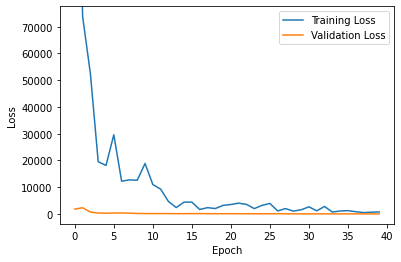

In [192]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [193]:
model.predict(x_test[0:1])

array([[10.347272 ,  4.2926536,  1.2227762,  2.8323667, 13.291482 ]],
      dtype=float32)

In [194]:
y_test[0:1]

array([[10.72,  0.18,  3.71,  2.42, 20.38]])

HGO Initial examples

In [123]:
# Example 1
# evaluated for unitary parameters. no dispersion

c= 1 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented along the pulling direction
theta = 0
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in kPa

2.14455419836872

In [124]:
# Example 2
#evaluated for unitary parameters. no dispersion

c= 0 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented transversal to the pulling direction
theta = 90


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in pressure units

0

In [125]:
# Example 3
# κ = 1/3, which means that the material is isotropic, i.e. Neo Hooke material.

c= 1 # pressure units
κ = 1/3
k1 = 1.0 # pressure units
k2 = 1.0
theta = 65


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in pressure units

0.621065104548954

In [126]:
# Example 4
# κ = 0.1, arbitrary orientation. 


c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
theta = 65


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress  # in pressure units

0.472149517852544

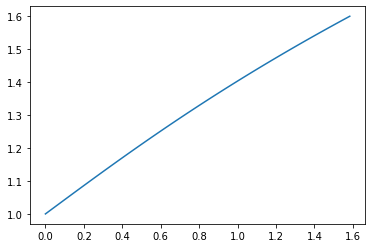

In [127]:
check = np.array(get_curve(params,1.0,1.6,50,"uniaxial"))
plt.plot(check,np.linspace(1.0,1.6,50))